# Data Preparation

## Install Libraries and Dependencies

In [1]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install tensorflow
%pip install scikit-learn
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
import kagglehub

2025-11-08 10:49:34.785564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762598975.068396      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762598975.158947      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Note: The dataset contains several accounts. However, only 'Savings Bank Account 1' and 'Cash' account are selected.

In [3]:
# Download latest version
path = kagglehub.dataset_download("prasad22/daily-transactions-dataset")
print("Path to dataset files:", path)

# Find the CSV file within the downloaded directory
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(path, filename)
        break

print("Path to CSV file:", csv_file_path)

df = pd.read_csv(csv_file_path, converters={'Date': str})
df.head(15)

Path to dataset files: /kaggle/input/daily-transactions-dataset
Path to CSV file: /kaggle/input/daily-transactions-dataset/Daily Household Transactions.csv


,Date,Mode,Category,Subcategory,Note,Amount,Income/Expense,Currency
0,20/09/2018 12:04:08,Cash,Transportation,Train,2 Place 5 to Place 0,30.0,Expense,INR
1,20/09/2018 12:03:15,Cash,Food,snacks,Idli medu Vada mix 2 plates,60.0,Expense,INR
2,19/09/2018,Saving Bank account 1,subscription,Netflix,1 month subscription,199.0,Expense,INR
3,17/09/2018 23:41:17,Saving Bank account 1,subscription,Mobile Service Provider,Data booster pack,19.0,Expense,INR
4,16/09/2018 17:15:08,Cash,Festivals,Ganesh Pujan,Ganesh idol,251.0,Expense,INR
5,15/09/2018 06:34:17,Credit Card,subscription,Tata Sky,Permanent Residence - Tata Play recharge,200.0,Expense,INR
6,14/09/2018 05:39:17,Cash,Transportation,auto,Place 2 station to Permanent Residence,50.0,Expense,INR
7,13/09/2018 21:35:15,Saving Bank account 1,Transportation,Train,2 Place 0 to Place 3,40.0,Expense,INR
8,13/09/2018 21:01:47,Credit Card,Other,NaN,HBR 2 Months subscription,83.0,Expense,INR
9,13/09/2018 21:01:32,Cash,Food,Grocery,1kg atta,46.0,Expense,INR


## Checking for Data Errors and Repetitions

In [4]:
# Checking for missing values in Date and Amount
missing_date = df['Date'].isnull().sum()
missing_amount = df['Amount'].isnull().sum()
print(f"Missing values in 'Date': {missing_date}\n")
print(f"Missing values in 'Amount': {missing_amount}\n")

# Count occurrences of each value in 'Income/Expense'
income_expense_counts = df['Income/Expense'].value_counts(dropna=False)
print('Occurrences of each value in', income_expense_counts)

# Print rows of Transfer-Out
transfer_out_rows = df[df['Income/Expense'] == 'Transfer-Out']
print('\nRows with Mode of Transfer-Out\n', transfer_out_rows)

# Count occurrences of each value in 'Mode'
mode_counts = df['Mode'].value_counts(dropna=False)
print('\nOccurrences of each value in', mode_counts)

# Count occurrences of each value in 'Category'
mode_counts = df['Category'].value_counts(dropna=False)
print('\nOccurrences of each value in', mode_counts)

Missing values in 'Date': 0

Missing values in 'Amount': 0

Occurrences of each value in Income/Expense
Expense         2176
Transfer-Out     160
Income           125
Name: count, dtype: int64

Rows with Mode of Transfer-Out
             Date                   Mode               Category Subcategory  \
10    13/09/2018  Saving Bank account 1       Small Cap fund 2         NaN   
11    13/09/2018  Saving Bank account 1       Small cap fund 1         NaN   
19      7/9/2018  Saving Bank account 1   Equity Mutual Fund E         NaN   
28      1/9/2018  Saving Bank account 1  Public Provident Fund         NaN   
29      1/9/2018   Equity Mutual Fund B  Saving Bank account 1         NaN   
...          ...                    ...                    ...         ...   
1669   10/1/2017  Saving Bank account 1   Equity Mutual Fund F         NaN   
1677    7/1/2017  Saving Bank account 1   Equity Mutual Fund E         NaN   
1683    5/1/2017  Saving Bank account 1      Recurring Deposit         N

**Notes:**
The transactions with a type of 'Transfer-Out' might indicate the movements of funds from one account to another. For example,

*   Savings Bank Account --> Equity Mutual Fund
*   Savings Bank Account --> Public Provident Fund

To simplify tracking fund movements especially when other accounts lack enough detail to trace transactions, I’ve decided to use only two accounts: 
1. Cash account
2. Saving Bank Account 1

These accounts don’t include ambiguous 'Transfer-Out' entries and provide more consistent data points for analysis.


## Filtering Transactions

In [5]:
# Rename Mode into Account
df = df.rename(columns={'Mode': 'Account'})

# Filter DataFrame to only include transactions related to "Savings Bank Account 1"
accounts_to_include = ['Cash', 'Saving Bank Account 1']
df = df[df['Account'].isin(accounts_to_include)]

In [6]:
# Count occurrences of each value in 'Income/Expense'
income_expense_counts = df['Income/Expense'].value_counts(dropna=False)
print('Occurrences of each value in', income_expense_counts)

Occurrences of each value in Income/Expense
Expense    1039
Income        7
Name: count, dtype: int64


The filtered datatset does not have any rows belong to 'Transfer-Out'

## Standardizing Date Format

In [7]:
# Identify rows with timestamp (dd/mm/yy hh:mm:ss)
timestamp_pattern = r'\d{2}/\d{2}/\d{4}\s\d{2}:\d{2}:\d{2}'
mask = df['Date'].str.match(timestamp_pattern)

# Convert only the rows with the timestamp to dd/mm/yyyy
df.loc[mask, 'Date'] = pd.to_datetime(df.loc[mask, 'Date'], dayfirst=True, errors='coerce').dt.strftime('%d/%m/%Y')

# Convert the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

df = df.set_index('Date')

df.head(15)

,Account,Category,Subcategory,Note,Amount,Income/Expense,Currency
Date,,,,,,,
2018-09-20,Cash,Transportation,Train,2 Place 5 to Place 0,30.0,Expense,INR
2018-09-20,Cash,Food,snacks,Idli medu Vada mix 2 plates,60.0,Expense,INR
2018-09-16,Cash,Festivals,Ganesh Pujan,Ganesh idol,251.0,Expense,INR
2018-09-14,Cash,Transportation,auto,Place 2 station to Permanent Residence,50.0,Expense,INR
2018-09-13,Cash,Food,Grocery,1kg atta,46.0,Expense,INR
2018-09-11,Cash,Food,Milk,Half lit milk,36.0,Expense,INR
2018-09-10,Cash,Food,Milk,Half lit milk,36.0,Expense,INR
2018-09-08,Cash,Family,Pocket money,NaN,40.0,Expense,INR
2018-09-07,Cash,Food,Milk,Half lit milk,37.0,Expense,INR


The length of dataset:  1046

Occurrences of each value in Category
Food                     483
Transportation           241
Household                 87
Other                     55
Health                    42
Family                    39
Apparel                   22
maid                      15
Beauty                    13
Festivals                 12
Education                  7
Culture                    5
Cook                       3
Grooming                   3
water (jar /tanker)        3
Gift                       3
Tourism                    2
Money transfer             2
subscription               2
garbage disposal           2
scrap                      2
Petty cash                 1
Gpay Reward                1
Public Provident Fund      1
Name: count, dtype: int64


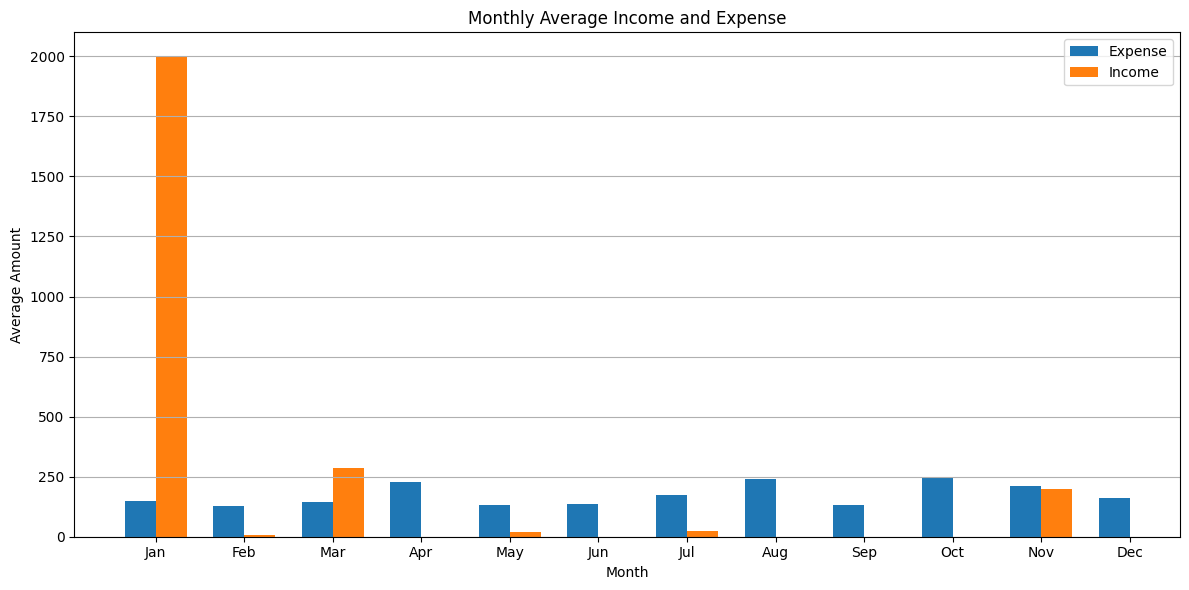

In [8]:
print("The length of dataset: ", len(df))

# Count occurrences of each value in 'Category'
category_counts = df['Category'].value_counts(dropna=False)
print('\nOccurrences of each value in', category_counts)

# Calculate average income and expense per month
monthly_avg = df.groupby([df.index.month, 'Income/Expense'])['Amount'].mean().unstack()

# Create a bar chart
plt.figure(figsize=(12, 6))

bar_width = 0.35
x_positions_expense = np.arange(len(monthly_avg))
x_positions_income = x_positions_expense + bar_width

# Plot the bars
plt.bar(x_positions_expense, monthly_avg['Expense'], width=bar_width, label='Expense')
plt.bar(x_positions_income, monthly_avg['Income'], width=bar_width, label='Income')

# Customize the chart
plt.title('Monthly Average Income and Expense')
plt.xlabel('Month')
plt.ylabel('Average Amount')
plt.xticks(x_positions_expense + bar_width / 2,
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Note: The person tends to spend more in April, August, and October.

## Checking for potential conflicts in 'Category' column

In [9]:
# Group the DataFrame by 'Category' and 'Income/Expense'
category_income_expense = df.groupby(['Category', 'Income/Expense']).size().unstack(fill_value=0)

# Identify categories that appear in both 'Income' and 'Expense'
categories_with_both = category_income_expense[(category_income_expense['Income'] > 0) & (category_income_expense['Expense'] > 0)]

if not categories_with_both.empty:
    print("**Categories linked to both 'Income' and 'Expense':**")
    print(categories_with_both)
    print("\n**Categories should be linked to either 'Income' or 'Expense', but not both**")
else:
    print("**All categories are correctly linked to either 'Income' or 'Expense'.**")

# Display the full mapping of categories to income/expense
print("\n**Full mapping of categories to 'Income/Expense':**")
print(category_income_expense)

**Categories linked to both 'Income' and 'Expense':**
Income/Expense  Expense  Income
Category                       
Other                52       3

**Categories should be linked to either 'Income' or 'Expense', but not both**

**Full mapping of categories to 'Income/Expense':**
Income/Expense         Expense  Income
Category                              
Apparel                     22       0
Beauty                      13       0
Cook                         3       0
Culture                      5       0
Education                    7       0
Family                      39       0
Festivals                   12       0
Food                       483       0
Gift                         3       0
Gpay Reward                  0       1
Grooming                     3       0
Health                      42       0
Household                   87       0
Money transfer               2       0
Other                       52       3
Petty cash                   0       1
Public Provident

The category 'Other' is linked to both 'Expense' and 'Income', making it unsuitable for further analysis. For that reason, I would exclude rows where 'Category' is 'Other'

In [10]:
# Remove rows where 'Category' is 'Other'
df = df[df['Category'] != 'Other']

# Display the number of remaining rows
print("Number of remaining rows:", len(df))

# Verify that 'Other' is not in the Category column
print("\nOccurrences of each value in Category after removal:")
print(df['Category'].value_counts(dropna=False))

Number of remaining rows: 991

Occurrences of each value in Category after removal:
Category
Food                     483
Transportation           241
Household                 87
Health                    42
Family                    39
Apparel                   22
maid                      15
Beauty                    13
Festivals                 12
Education                  7
Culture                    5
Cook                       3
Grooming                   3
water (jar /tanker)        3
Gift                       3
Tourism                    2
Money transfer             2
subscription               2
garbage disposal           2
scrap                      2
Petty cash                 1
Gpay Reward                1
Public Provident Fund      1
Name: count, dtype: int64


# Feature Engineering


## Derive Daily Net Cash Flow

In [11]:
# Calculate daily net cashflows
df['NetCashflow'] = df.apply(lambda x: x['Amount'] if x['Income/Expense'] == 'Income' else -x['Amount'], axis=1)

## Number of Transactions and Categories Per Day

In [12]:
def aggregate_transactions(group):
    """Calculates DailyNetCashflow, NumberOfTransactions, ExpenseCategory, and IncomeCategory."""
    expense_categories = group[group['Income/Expense'] == 'Expense']['Category'].value_counts().to_dict()
    income_categories = group[group['Income/Expense'] == 'Income']['Category'].value_counts().to_dict()

    data = {
        'DailyNetCashflow': group['NetCashflow'].sum(),
        'NumberOfTransactions': group['Amount'].count(),
        'ExpenseCategory': sum(expense_categories.values()),
        'IncomeCategory': sum(income_categories.values())
    }
    return pd.Series(data)

# Apply the aggregation function
df = df.groupby('Date').apply(aggregate_transactions)

# Now `df` contains the desired features
df.head(15)

,DailyNetCashflow,NumberOfTransactions,ExpenseCategory,IncomeCategory
Date,,,,
2015-01-01,-552.0,10.0,10.0,0.0
2015-01-02,-104.0,3.0,3.0,0.0
2015-01-03,-399.0,2.0,2.0,0.0
2015-01-04,-230.0,3.0,3.0,0.0
2015-01-06,-30.0,2.0,2.0,0.0
2015-01-07,-31.0,1.0,1.0,0.0
2015-01-08,-20.0,1.0,1.0,0.0
2015-01-09,-20.0,1.0,1.0,0.0
2015-01-10,-70.0,2.0,2.0,0.0


### Visualization of ExpenseCategory & IncomeCategory

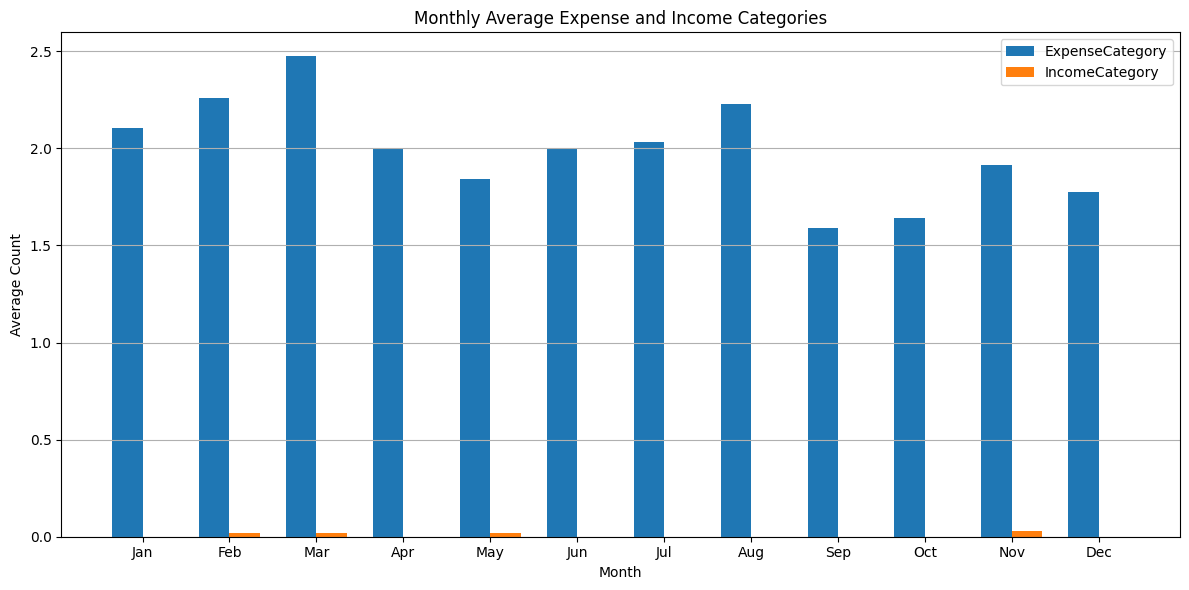

In [13]:
# Group data by month and calculate the average ExpenseCategory and IncomeCategory
monthly_avg_expense = df.groupby(df.index.month)['ExpenseCategory'].mean()
monthly_avg_income = df.groupby(df.index.month)['IncomeCategory'].mean()

# Create a bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Define bar width and positions
bar_width = 0.35
x_positions_expense = np.arange(len(monthly_avg_expense))
x_positions_income = x_positions_expense + bar_width

# Plot the bars
plt.bar(x_positions_expense, monthly_avg_expense.values, width=bar_width, label='ExpenseCategory')
plt.bar(x_positions_income, monthly_avg_income.values, width=bar_width, label='IncomeCategory')

# Customize the chart
plt.title('Monthly Average Expense and Income Categories')
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.xticks(x_positions_expense + bar_width / 2,
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### Visualization of Daily Net Cashflow (2015-2018)

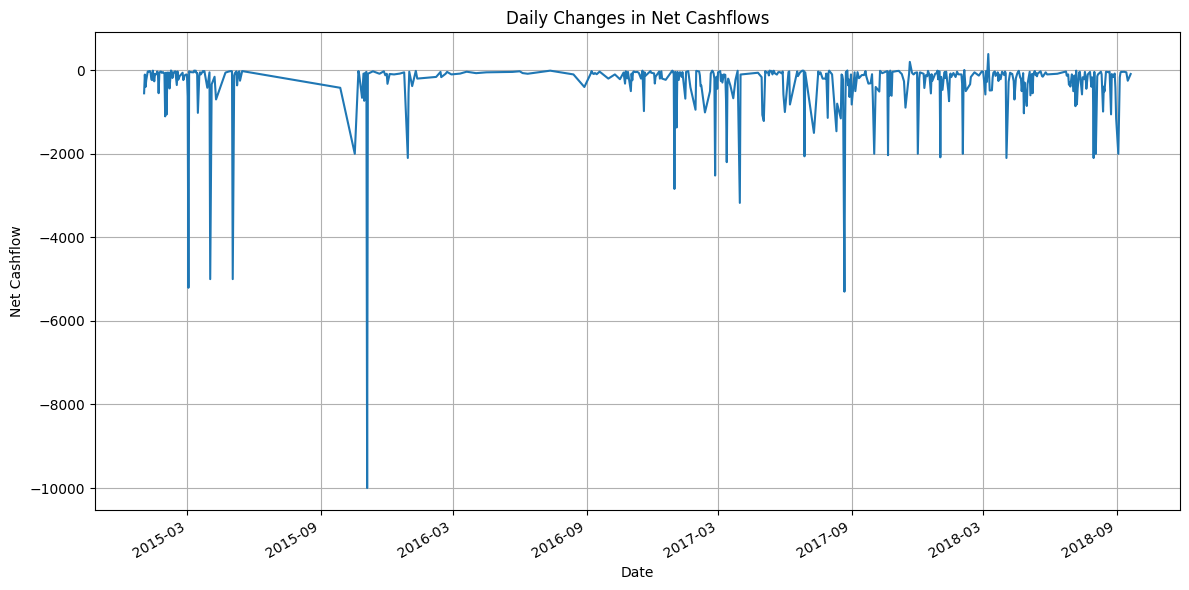

In [14]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['DailyNetCashflow'])
plt.title('Daily Changes in Net Cashflows')

# Formatting date axis
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=6))  # Interval every 6 month
plt.gcf().autofmt_xdate()  # Rotate dates

plt.xlabel('Date')
plt.ylabel('Net Cashflow')
plt.grid(True)
plt.tight_layout()
plt.show()


Note: There are periods of no transactions. However, this absence of activity still carries a significant piece of information, and carries meaning in itself. For example, if 0.0 net cash flows regularly occur on certain days, that could be a useful pattern.

In [15]:
# Create a complete date range
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame with the complete date range
df = df.reindex(date_range)

# Convert NaN to 0.0 as it indicates none transaction
df['DailyNetCashflow'] = df['DailyNetCashflow'].fillna(0.0)
df['NumberOfTransactions'] = df['NumberOfTransactions'].fillna(0.0)
df['ExpenseCategory'] = df['ExpenseCategory'].fillna(0.0)
df['IncomeCategory'] = df['IncomeCategory'].fillna(0.0)

# Save or use the augmented data
df.to_csv('augmented_dataset.csv', index=False)

print(df)

            DailyNetCashflow  NumberOfTransactions  ExpenseCategory  \
2015-01-01            -552.0                  10.0             10.0   
2015-01-02            -104.0                   3.0              3.0   
2015-01-03            -399.0                   2.0              2.0   
2015-01-04            -230.0                   3.0              3.0   
2015-01-05               0.0                   0.0              0.0   
...                      ...                   ...              ...   
2018-09-16            -251.0                   1.0              1.0   
2018-09-17               0.0                   0.0              0.0   
2018-09-18               0.0                   0.0              0.0   
2018-09-19               0.0                   0.0              0.0   
2018-09-20             -90.0                   2.0              2.0   

            IncomeCategory  
2015-01-01             0.0  
2015-01-02             0.0  
2015-01-03             0.0  
2015-01-04             0.0  
20

Visualize daily net cash flows after date reindexing

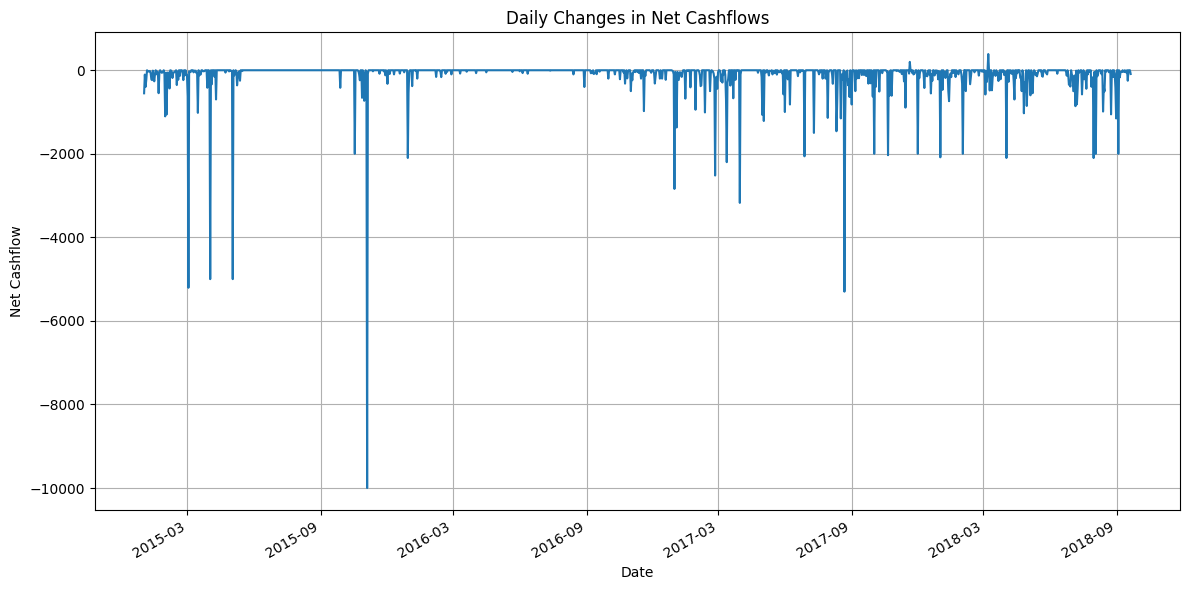

In [16]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['DailyNetCashflow'])
plt.title('Daily Changes in Net Cashflows')

# Formatting date axis
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=6))  # Interval every 6 month
plt.gcf().autofmt_xdate()  # Rotate dates

plt.xlabel('Date')
plt.ylabel('Net Cashflow')
plt.grid(True)
plt.tight_layout()
plt.show()

Visualize the number of occurences of no transactions for each day of the  week

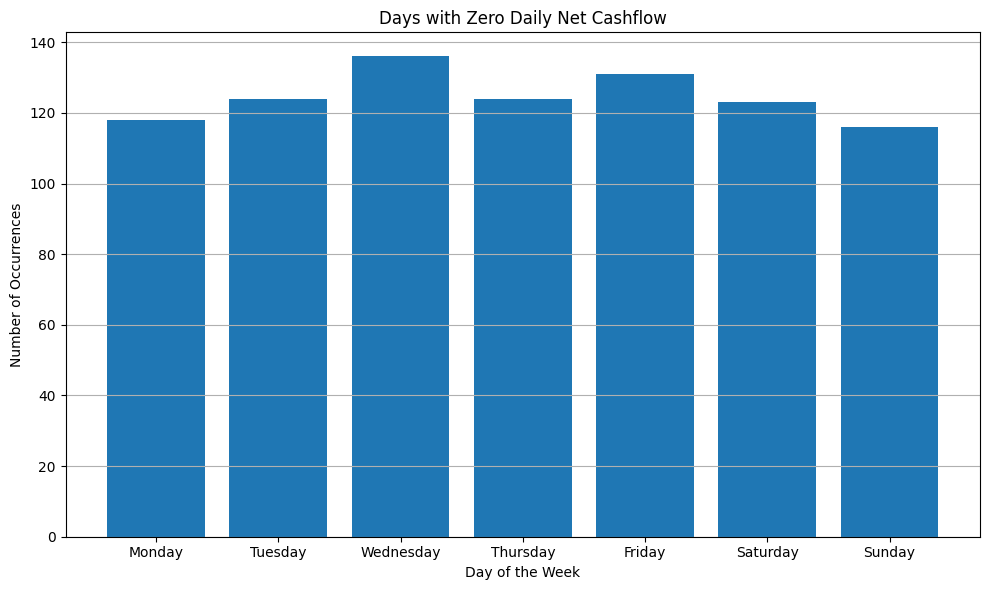

In [17]:
# Filter for days where DailyNetCashflow is 0
zero_cashflow_days = df[df['DailyNetCashflow'] == 0]

# Extract day of the week for zero cashflow days
zero_cashflow_days_of_week = zero_cashflow_days.index.day_name()

# Count the occurrences of each day of the week
day_counts = zero_cashflow_days_of_week.value_counts()

# Order the days of the week for plotting
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_counts = day_counts.reindex(days_order, fill_value=0)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(day_counts.index, day_counts.values)

# Customize the chart
plt.title('Days with Zero Daily Net Cashflow')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Occurrences')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Note: The net cash flows of 0.0 is less likely to occur on Sunday.

### Visualization of Average DailyNetCashflow per Month

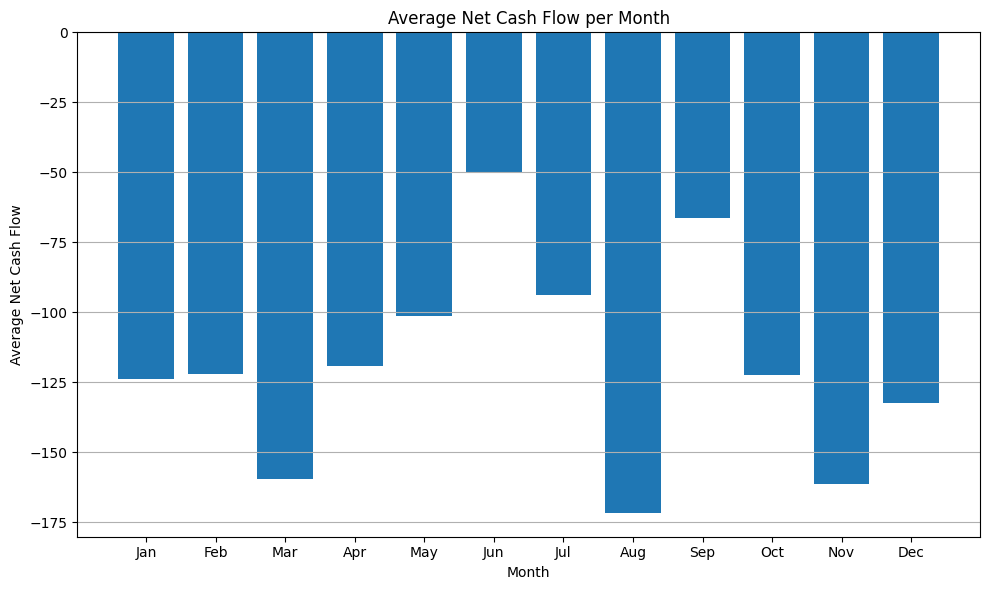

In [18]:
# Group data by month and calculate the average net cash flow
monthly_avg_netcashflow = df.groupby(df.index.month)['DailyNetCashflow'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(monthly_avg_netcashflow.index, monthly_avg_netcashflow.values)

# Customize the chart
plt.title('Average Net Cash Flow per Month')
plt.xlabel('Month')
plt.ylabel('Average Net Cash Flow')
plt.xticks(monthly_avg_netcashflow.index,
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Set x-axis labels
plt.grid(axis='y')

plt.tight_layout()
plt.show()

Note: The person tends to spend more on March, August, and November.

In [19]:
# Convert all numerical features to float
for column in df.columns:
    if df[column].dtype != np.float64:
        df[column] = df[column].astype(np.float64)

df.to_csv('final_dataset.csv', index=False)
df.head(10)

,DailyNetCashflow,NumberOfTransactions,ExpenseCategory,IncomeCategory
2015-01-01,-552.0,10.0,10.0,0.0
2015-01-02,-104.0,3.0,3.0,0.0
2015-01-03,-399.0,2.0,2.0,0.0
2015-01-04,-230.0,3.0,3.0,0.0
2015-01-05,0.0,0.0,0.0,0.0
2015-01-06,-30.0,2.0,2.0,0.0
2015-01-07,-31.0,1.0,1.0,0.0
2015-01-08,-20.0,1.0,1.0,0.0
2015-01-09,-20.0,1.0,1.0,0.0
2015-01-10,-70.0,2.0,2.0,0.0


In [20]:
# Checking for potential NaN
print("NaN in features:", np.isnan(df.values).any())
print("Infinite in features:", np.isinf(df.values).any())

NaN in features: False
Infinite in features: False


### Visualization of Number of Transactions per Month

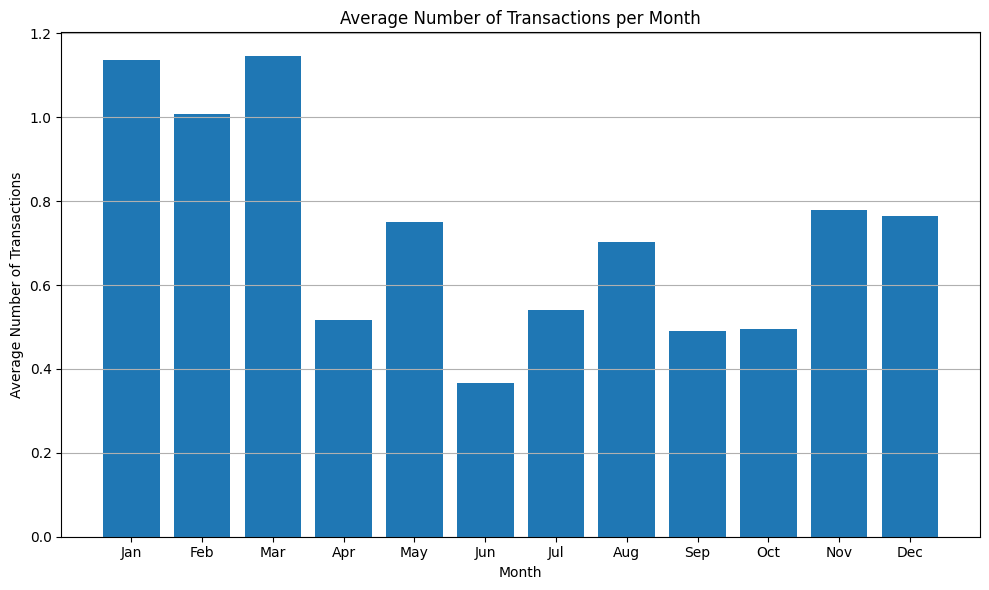

In [21]:
# Group data by month and calculate the average net cash flow
monthly_avg_numOfTransaction = df.groupby(df.index.month)['NumberOfTransactions'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(monthly_avg_numOfTransaction.index, monthly_avg_numOfTransaction.values)

# Customize the chart
plt.title('Average Number of Transactions per Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Transactions')
plt.xticks(monthly_avg_numOfTransaction.index,
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Set x-axis labels
plt.grid(axis='y')

plt.tight_layout()
plt.show()

## Derive Date-Based Features - Seasonality

Date-based features are important to determine seasonalities.

In [22]:
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['DayOfMonth'] = df.index.day

# Verify the result
df.head(15)

,DailyNetCashflow,NumberOfTransactions,ExpenseCategory,IncomeCategory,DayOfWeek,Month,Quarter,DayOfMonth
2015-01-01,-552.0,10.0,10.0,0.0,3,1,1,1
2015-01-02,-104.0,3.0,3.0,0.0,4,1,1,2
2015-01-03,-399.0,2.0,2.0,0.0,5,1,1,3
2015-01-04,-230.0,3.0,3.0,0.0,6,1,1,4
2015-01-05,0.0,0.0,0.0,0.0,0,1,1,5
2015-01-06,-30.0,2.0,2.0,0.0,1,1,1,6
2015-01-07,-31.0,1.0,1.0,0.0,2,1,1,7
2015-01-08,-20.0,1.0,1.0,0.0,3,1,1,8
2015-01-09,-20.0,1.0,1.0,0.0,4,1,1,9
2015-01-10,-70.0,2.0,2.0,0.0,5,1,1,10


# LSTM Model

## Data Splitting

Split data into training and testing before windowing and normalization



*   80% of dataset is allocated for training
*   20% of dataset is allocated for testing

Add 7-days gap between training and testing datasets to avoid potential overlap during windowing.

In [23]:
# Determine splitting point
train_ratio = 0.8
# Gaps between training and testing sets
gap_days = 30

split_index = int(len(df) * train_ratio)
train_end_date = df.index[split_index]
test_start_date = train_end_date + pd.Timedelta(days=gap_days)

# Split the Data
train_data = df.loc[:train_end_date]
test_data = df.loc[test_start_date:]

In [24]:
print("Length of train_data:", len(train_data))
print("Length of test_data:", len(test_data))

Length of train_data: 1088
Length of test_data: 242


## Windowing

Each window is split into 2 parts:

1) The 'input', which the LSTM model will use to learn patterns, and

2) The 'output', which is the target variable or value the model will try to predict.

In [25]:
# Predict DailyNetCashflow for multiple future time steps using an autoregressive LSTM
def create_dataset(df, input_width=7, output_width=28, shift=1):
    """
    Creates a dataset of input windows and output labels.

    Args:
        df (pd.DataFrame): Input DataFrame with features and Date index.
        input_width (int): Number of time steps in the input window (lookback).
        output_width (int): Number of time steps to predict (forecast horizon).
        shift (int): Time step shift between input and output.

    Returns:
        tf.data.Dataset: Dataset of (input_window, output_label) pairs.
    """

    # Convert DataFrame to NumPy array for TensorFlow
    features = df[['DailyNetCashflow', 'NumberOfTransactions', 'ExpenseCategory', 'IncomeCategory', 'DayOfWeek', 'Month', 'Quarter', 'DayOfMonth']]

    # Create dataset from array
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=features,
        targets=None,  # Targets will be created below
        sequence_length=input_width + output_width, # Total window size
        sequence_stride=1, # Step size (1 day)
        shuffle=False, # Ensure correct order of time series data
        batch_size=32
    )

    def split_window(features):
        inputs = features[:, :input_width, :]  # Input window
        labels = features[:, input_width:input_width + output_width, 0:1] # Output is DailyNetCashflow
        return inputs, labels

    return ds.map(split_window)

In [26]:
train_dataset = create_dataset(train_data, input_width=7, output_width=28)
test_dataset = create_dataset(test_data, input_width=7, output_width=28)

2025-11-08 10:49:55.829332: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Print the shape of dataset (3D)

In [27]:
# Look at the first batch of each dataset
for inputs, labels in train_dataset.take(1):
    print("Input shape (train):", inputs.shape)
    print("Label shape (train):", labels.shape)

for inputs, labels in test_dataset.take(1):
    print("Input shape (test):", inputs.shape)
    print("Label shape (test):", labels.shape)

Input shape (train): (32, 7, 8)
Label shape (train): (32, 28, 1)
Input shape (test): (32, 7, 8)
Label shape (test): (32, 28, 1)


Train (input) has a batch size of 32, 8 time steps and 7 features.

Train (label) has a batch size of 32, 1 time step, and 1 target variable.

Test (input) has a batch size of 32, 7 time steps and 8 features.

Test (label) has a batch size of 32, 1 time step and 1 target variable.

Interpretation: This means the LSTM model will look at 32 batches at a time, each with a sequence of 7 days, and 7 features and the model would try predicting the DailyNetCashflow for the next 30 days.

Print the first 2 rows of each dataset

In [28]:
for i, (inputs, labels) in enumerate(train_dataset.take(2)):
    print(f"Window {i + 1}:")
    print("Inputs (train):")
    print(inputs.numpy())
    print("Labels (train):")
    print(labels.numpy())
    print("-" * 20)

for i, (inputs, labels) in enumerate(test_dataset.take(2)):
    print(f"Window {i + 1}:")
    print("Inputs (test):")
    print(inputs.numpy())
    print("Labels (test):")
    print(labels.numpy())
    print("-" * 20)

Window 1:
Inputs (train):
[[[-5.520e+02  1.000e+01  1.000e+01 ...  1.000e+00  1.000e+00  1.000e+00]
  [-1.040e+02  3.000e+00  3.000e+00 ...  1.000e+00  1.000e+00  2.000e+00]
  [-3.990e+02  2.000e+00  2.000e+00 ...  1.000e+00  1.000e+00  3.000e+00]
  ...
  [ 0.000e+00  0.000e+00  0.000e+00 ...  1.000e+00  1.000e+00  5.000e+00]
  [-3.000e+01  2.000e+00  2.000e+00 ...  1.000e+00  1.000e+00  6.000e+00]
  [-3.100e+01  1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00  7.000e+00]]

 [[-1.040e+02  3.000e+00  3.000e+00 ...  1.000e+00  1.000e+00  2.000e+00]
  [-3.990e+02  2.000e+00  2.000e+00 ...  1.000e+00  1.000e+00  3.000e+00]
  [-2.300e+02  3.000e+00  3.000e+00 ...  1.000e+00  1.000e+00  4.000e+00]
  ...
  [-3.000e+01  2.000e+00  2.000e+00 ...  1.000e+00  1.000e+00  6.000e+00]
  [-3.100e+01  1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00  7.000e+00]
  [-2.000e+01  1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00  8.000e+00]]

 [[-3.990e+02  2.000e+00  2.000e+00 ...  1.000e+00  1.000e+00  3.000e+

## Data Normalization

Some features like 'DailyNetCashflow' can have a very wide range (e.g., -1000 to 80000), while others like 'DayOfWeek' have a much smaller range (1 to 7). This difference in scales can cause problems for LSTM models. This may lead to:



*   **Domination by Large Features**: The
'DailyNetCashflow' feature might dominate the learning process, overshadowing the impact of other features like 'DayOfWeek' or 'Month'

*   **Slower Convergence**: The optimization algorithm might take longer to converge because the gradients for different features will be on vastly different scales

Normalization helps to mitigate these issues by bringing all your features to a similar scale (0 to 1). The potential benefits include:



*   **Balances Feature Influence**: Allows the LSTM to learn equally from all features, preventing bias towards features with larger values

*   **Faster Training**: Helps the optimization process converge more quickly, potentially leading to a better model in fewer epochs

*   **Enhanced Stability**: Reduces the chance of exploding or vanishing gradients, which can destabilize LSTM training

In [29]:
# Function to extract data from the dataset
def extract_data(dataset):
    """Extract features and labels from the dataset."""
    inputs = []
    labels = []
    for input_batch, label_batch in dataset:
        inputs.extend(input_batch.numpy())
        labels.extend(label_batch.numpy())
    return np.array(inputs), np.array(labels)

In [30]:
# Extract data from train and test datasets
train_x, train_y = extract_data(train_dataset)
test_x, test_y = extract_data(test_dataset)

In [31]:
from sklearn.preprocessing import MinMaxScaler
# Apply separate MinMaxScaler to datasets
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

train_x_scaled = scaler_x.fit_transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
test_x_scaled = scaler_x.transform(test_x.reshape(-1, test_x.shape[-1])).reshape(test_x.shape)

train_y_scaled = scaler_y.fit_transform(train_y.reshape(-1, train_y.shape[-1])).reshape(train_y.shape)
test_y_scaled = scaler_y.transform(test_y.reshape(-1, test_y.shape[-1])).reshape(test_y.shape)

Note: During the process, I reshape the input data (train_x and test_x, train_y and test_y) into 2D array before scaling to ensure that the scaler is applied to all features individually. For the test data, I only want to apply the scaling using the minimum and maximum values that were learned from the training data. Upon successful scaling, the data would be restored into their original 3D.

In [32]:
# After scaling: Checking for potential NaN
print("NaN in training data (scaled):", np.isnan(train_x_scaled).any())
print("Infinite in training data (scaled):", np.isinf(train_x_scaled).any())

print("NaN in testing data (scaled):", np.isnan(test_x_scaled).any())
print("Infinite in testing data (scaled):", np.isinf(test_x_scaled).any())

NaN in training data (scaled): False
Infinite in training data (scaled): False
NaN in testing data (scaled): False
Infinite in testing data (scaled): False


## Defining LSTM Model

In [33]:
# Define LSTM model
model = Sequential([
    LSTM(units=128, activation="relu", input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True),
    Dropout(0.2),

    LSTM(units=64, return_sequences=True),
    Dropout(0.2),

    LSTM(units=32),
    Dropout(0.2),

    Dense(units=28)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('The output shape:' , model.output_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 128)              │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 28)                  │             924 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 132,892 (519.11 KB)

 Trainable params: 132,892 (519.11 KB)

 Non-trainable params: 0 (0.00 B)

The output shape: (None, 28)


## Training & Measuring Performance

In [34]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/kaggle/working/balance_prediction/best_model_weights8.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_x_scaled, train_y_scaled,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 0.8947 - val_loss: 0.5566
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5003 - val_loss: 0.1742
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2220 - val_loss: 0.0428
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1295 - val_loss: 0.0103
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0952 - val_loss: 0.0062
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0811 - val_loss: 0.0068
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0689 - val_loss: 0.0061
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0637 - val_loss: 0.0052
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0601 - val_loss: 0.0055
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0536 - val_loss: 0.0043
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0496 - val_loss: 0.0037
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

In [35]:
best_model = tf.keras.models.load_model('/kaggle/working/balance_prediction/best_model_weights8.keras')
test_loss = best_model.evaluate(test_x_scaled, test_y_scaled)
print("Test Loss:", test_loss)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013  
Test Loss: 0.0014641023008152843


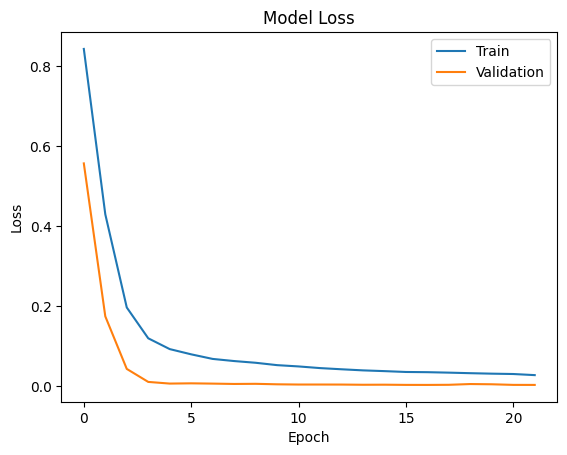

In [36]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Prepare Actual and Projected Values

The values of test y were previously scaled using MinMaxScaler. In order to compare actual and projected daily net cashflow, I would perform inverse scaling on the data

In [37]:
# y_true values (1D)
test_y_actual = scaler_y.inverse_transform(test_y_scaled.reshape(-1, 1))[:, 0]

In [38]:
print(test_y_actual[:5])

[    0.  -100.  -320. -2000.  -170.]


In [39]:
# Predict daily net cashflow with the best model
projection = best_model.predict(test_x_scaled)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


In [40]:
print(projection.shape)
print(projection[:5])

(208, 28)
[[0.9450126  0.95394516 0.940053   0.92875344 0.96271026 0.947958
  0.94862527 0.94554293 0.9648661  0.93888503 0.9722998  0.94920987
  0.9289146  0.9563254  0.9468626  0.9605451  0.95873696 0.9614127
  0.9401663  0.9183638  0.9514083  0.961649   0.94878817 0.9628494
  0.94252646 0.9585885  0.9373484  0.9317976 ]
 [0.94469804 0.95445645 0.939858   0.9265287  0.96218055 0.9452472
  0.94805384 0.9454438  0.9655317  0.9386957  0.9726602  0.9500422
  0.9260998  0.9579917  0.9478294  0.9592034  0.9563704  0.96088165
  0.93823904 0.9155545  0.95250404 0.9612027  0.9469609  0.9610655
  0.94485956 0.9568106  0.9335707  0.928555  ]
 [0.945139   0.95508665 0.9401007  0.9251463  0.9615475  0.94354504
  0.94776785 0.9458159  0.96654284 0.93899065 0.9735124  0.95106465
  0.9244689  0.9599031  0.9491219  0.9583245  0.9541632  0.9608062
  0.93703765 0.9131924  0.9535399  0.9611367  0.9458678  0.9596308
  0.94755864 0.95575404 0.9310056  0.92603457]
 [0.9470255  0.95723987 0.9419566  0.92655

The projection is 2D array and is scaled. I will inverse the scaling and convert it to 1D array.

In [41]:
projection = scaler_y.inverse_transform(projection)
projection = projection.reshape(-1)
print(projection.shape)
print(projection[:5])

(5824,)
[-360.8712  -269.75937 -411.45956 -526.71497 -180.35533]


In [42]:
# Calculate the evaluation metrics
mae = mean_absolute_error(test_y_actual, projection)
mse = mean_squared_error(test_y_actual, projection)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 277.5658226818829
Mean Squared Error (MSE): 152325.20560499042
Root Mean Squared Error (RMSE): 390.2886183390318


## Visualizing Projection vs Actual

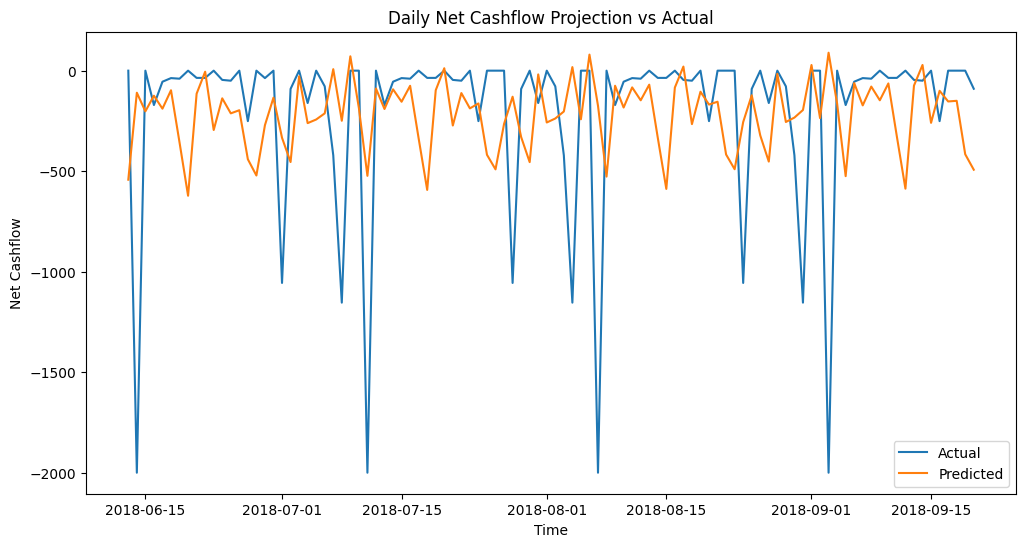

In [43]:
# Plotting predicted and actual cumulative balance
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], test_y_actual[-100:], label='Actual')
plt.plot(df.index[-100:], projection[-100:], label='Predicted')
plt.title('Daily Net Cashflow Projection vs Actual')
plt.xlabel('Time')
plt.ylabel('Net Cashflow')
plt.legend()
plt.show()

While the neural network's predictions weren't numerically precise—as indicated by the Mean Absolute Error—it consistently captured the directional trend of daily net cash flows, correctly identifying whether they moved up or down.

**Credit:**
The dataset is retrieved from https://www.kaggle.com/datasets/prasad22/daily-transactions-dataset